In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

from dipy.io.image import save_nifti
import numpy as np
import learning
from dipy.data import read_stanford_hardi, read_stanford_pve_maps
import torch
import torch.nn as nn
from syn_data import SynDiffData
from water_correction import dehydrate
from dipy.segment.mask import median_otsu

from scipy.ndimage.morphology import binary_erosion

### Load data

In [3]:
# Diffusion weighted data
img, gtab = read_stanford_hardi()
dwi = img.get_data()

# Segmentation maps
(csf, gm, wm) = [map.get_data()==1.0 for map in read_stanford_pve_maps()]

# The provided segmentation maps are quite noisy in the lower parts of the brain, so we clip the segmentation maps 
# at z=25, and use only the ventricles for CSF data.
v_mask = np.zeros(csf.shape)
(x,y,z) = np.divide(csf.shape,2).astype(np.int)
v_mask[x-15:x+15,y-20:y+20,z-5:z+5] = 1
csf = np.logical_and(csf, v_mask)

wm[:,:,:25] = 0
gm[:,:,:25] = 0

# Erode the maps so obtained exemplary voxels are not contaminated by other tissue
csf, gm, wm = [binary_erosion(map) for map in (csf, gm, wm)]

maskdata, mask = median_otsu(dwi, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/leon/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/leon/.dipy/stanford_hardi 


### Create the synthetic training data set

In [4]:
synDataLoader = SynDiffData(gtab, dwi, csf_mask=csf, gm_mask=gm, wm_mask=wm)
syn_diff_data, water_fraction = synDataLoader.create_waterfraction_data(sample_size=25000) # this may take a while

### Neural network training

In [30]:
net = learning.Net(synDataLoader.datashape, 1)

optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
num_epochs = 100
criterion = nn.MSELoss()

mse, me = learning.train(syn_diff_data, water_fraction, net, criterion, num_epochs, optimizer)

Epoch 0: MSE=0.0024831478520609485, ME=0.04246951006981681
Epoch 10: MSE=0.0008401013165549508, ME=0.02235586149794303
Epoch 20: MSE=0.0008323013230103829, ME=0.0224046579641112
Epoch 30: MSE=0.0008406016717318252, ME=0.022457569350659314
Epoch 40: MSE=0.0008375967515014497, ME=0.022670688616108613
Epoch 50: MSE=0.0008589505545898398, ME=0.023173349076890663
Epoch 60: MSE=0.0008659109166257526, ME=0.02322832810058901
Epoch 70: MSE=0.0008290077595264249, ME=0.022461744809970294
Epoch 80: MSE=0.0008413394563662255, ME=0.022602005747934015
Epoch 90: MSE=0.0008386189589607835, ME=0.02250650478441982


### Predict and correct the water fraction in the original data

In [31]:
f_fw_predicted, dwi_water_corrected = dehydrate(maskdata, mask, synDataLoader, net)

### Visualizations and save data

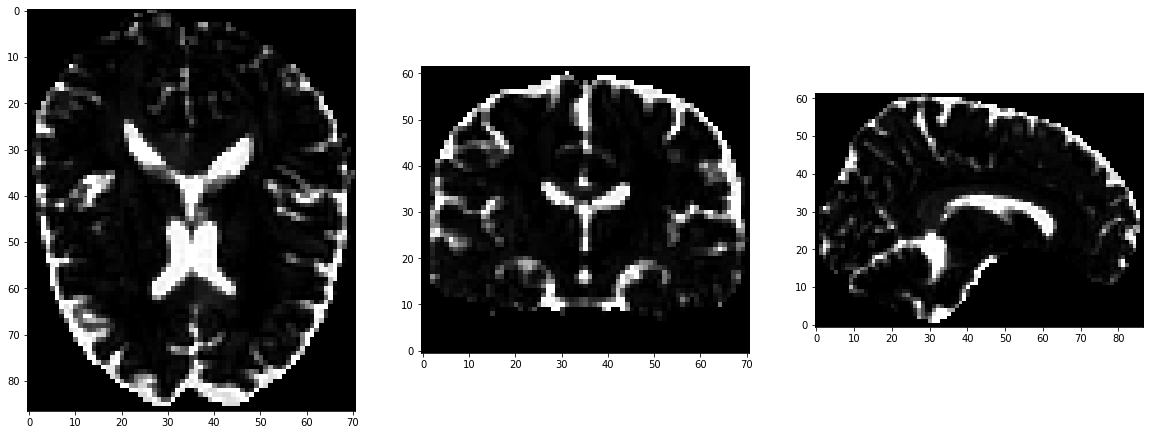

In [32]:
plt.rcParams["figure.figsize"] = (20,10)
plt.figure('water fraction')
plt.subplot(1, 3, 1)
plt.imshow(f_fw_predicted[:,:,30].T, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(f_fw_predicted[:,40,:].T, origin='lower', cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(f_fw_predicted[30,:,:].T, origin='lower', cmap='gray')

save_nifti("f_fw.nii.gz", f_fw_predicted, img.affine)
save_nifti("dwi_fwe.nii.gz", dwi_water_corrected, img.affine)
